# Classification Project 1

3/2/2020

For this assignment we will implement several KNN classifiers on the MNIST data set. 

We downloaded the MNIST data set from http://yann.lecun.com/exdb/mnist/. There is a training data set and a test data set. Each image is 28x28 pixels.

Aside from the associated intructions to load the data, we found the following resources useful for visualizing MNIST data, and creating a model with leave-one-out cross validation. 

https://github.com/ibodumas/naivebayes_mnist/blob/master/Classification_MNIST_NaiveBayes.ipynb

https://github.com/nmolivo/Blogs/blob/master/001_LOOCV/blog_001-LOOCV.ipynb

In [1]:
import os, gzip, shutil, codecs
import numpy as np
import pandas as pd
import sklearn
import prettytable
import skimage.measure
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
from sklearn import neighbors, metrics
from sklearn.metrics import confusion_matrix
from prettytable import PrettyTable

##### Extract and convert ubyte data to numpy array #####
We will setup a `path_in` that contains the .gz files, and a `path_out` to put the extracted files into. Then we iterate over the files and capture the ubyte information and naming convention. We then export the image data to a dictionary. When importing and converting data, we use an 8-bit integer to reduce the size of the array. 

In [2]:
os.getcwd()

'/Users/clou/Desktop/git_control/mtu_ml_proj_team/classification/classification1'

In [3]:
"""
unzip and load data

"""
path_in = os.getcwd()+'/raw_data/'
path_out = os.getcwd()+'/extracted/'
files_in = os.listdir(path_in)
files_out = os.listdir(path_out)
# print("original data: ", files_in)
    
for file in files_in:
    if file.endswith('gz'):
        with gzip.open(path_in + file, mode='rb') as f_in:
            with open(path_out + file.split('.')[0], mode='wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
                files_out = os.listdir(path_out)

                
"""
convert ubyte file to numpy array

32 bits = 4 bytes
offset 0-3: magic number { 2049 is label file ; 2051 is image file }
offset 4-7: array length


label file:

offset 8:      label value (0-9)
offset 9:      label value (0-9)
offset ???:    label value (0-9)


image file: 

offset 8-11:   number of rows
offset 12-15:  number of columns
offset 16:     1 pixel value 
offset 17:     1 pixel value
offset ???:    1 pixel value 

"""


my_dic = {}
for file1 in files_out:
    if file1.endswith('ubyte'):
        with open(path_out + file1, mode='rb') as f:
            my_data = f.read()
            # file type check
            magic_num = int(codecs.encode(my_data[0:4], 'hex'), 16)
            # file length check
            num_len = int(codecs.encode(my_data[4:8], 'hex'), 16)
            # print(num_len, magic_num)
            # train len: 60000; test len: 10000 
            if num_len == 10000:
                length = 'test'
            elif num_len == 60000:
                length = 'train'
                
            if magic_num == 2049:
                # start from offset 8, convert one label to an integer each time
                lab = np.frombuffer(my_data, np.uint8, offset=8)
                parse = lab.reshape(num_len)
                # print(lab)
                cat = 'label'
            elif magic_num == 2051:
                # rows from offset 8 - 11
                rows = int(codecs.encode(my_data[8:12], 'hex'), 16)
                # colmns from offset 12 - 15
                cols = int(codecs.encode(my_data[12:16], 'hex'), 16)
                # start from offset 16, convert one pixel to an integer each time
                pix = np.frombuffer(my_data, np.uint8, offset=16)
                parse = pix.reshape(num_len, rows, cols)
                cat = 'image'
            
            my_dic[cat + '_' + length] = parse

print(my_dic.keys())
print('image_test shape: ' + str(my_dic['image_test'].shape))
print('label_test shape: ' + str(my_dic['label_test'].shape))
print('image_train shape: ' + str(my_dic['image_train'].shape))
print('label_train shape: ' + str(my_dic['label_train'].shape))
# my_dic['label_test']

dict_keys(['image_test', 'label_test', 'image_train', 'label_train'])
image_test shape: (10000, 28, 28)
label_test shape: (10000,)
image_train shape: (60000, 28, 28)
label_train shape: (60000,)


We can set up our testing and training data from our image dictionary for both the data, X, and target/response/classification, y.

In [4]:
# reshape arrays by flattening 28x28 image into a 784 dimension vector
X_train, y_train = my_dic['image_train'].reshape(60000, 28*28), my_dic['label_train']
X_test, y_test = my_dic['image_test'].reshape(10000, 28*28), my_dic['label_test']
print('X_train shape: ' + str(X_train.shape))
print('X_test shape: ' + str(X_test.shape))
print('y_train shape: ' + str(y_train.shape))
print('y_test shape: ' + str(y_test.shape))

X_train shape: (60000, 784)
X_test shape: (10000, 784)
y_train shape: (60000,)
y_test shape: (10000,)


##### i) (10 pts) Implement a 1-nearest neighbor classifier that considers the image pixels to be one long feature vector. The vector will be 28*28 = 784-dimensions long (one feature for each pixel in the image). Do not do any scaling or normalization on the pixel values. Present the testing error for each digit in a table.
Because the leave-one-out cross validation is so computationally expensive, yet highly accurate, we will take a random sample of 2000 images from the training dataset to complete the following analysis. The index will be stored in `randindex` so that we can ensure we use the same data across each model. We can also check to make sure our target, labels, have relatively equal frequencies.

In [5]:
np.random.RandomState(200)
randindex=np.random.randint(len(X_train),size=2000)
print('Random Index of length ' +str(len(randindex))+':')
print(randindex)
target=y_train[randindex]
unique, counts = np.unique(target, return_counts=True)
print('Frequency of Training Labels:')
print(np.asarray((unique, counts)))

Random Index of length 2000:
[30180 36534 10974 ... 28424 19742 40565]
Frequency of Training Labels:
[[  0   1   2   3   4   5   6   7   8   9]
 [182 212 216 219 185 196 170 219 205 196]]


We can quickly fit a single nearest neighbors classifier and test it on the first 1000 images from the test dataset.

In [6]:
# fitting
knn = neighbors.KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train[randindex],y_train[randindex])
# prediction on first 1000 points from test dataset
y_pred = knn.predict(X_test[1:1000])
# comfusion matrix
cm = confusion_matrix(y_pred, y_test[1:1000])
# print(c)
# print(c.sum(axis=0)) # sum of each col
# print(c.sum(axis=1)) # sum of each row
# print(np.diag(c))
"""
tp: true positive  |  tn: true negative  | fp: false positive  | fn: false negative
accuracy = tp + tn / (tp + tn + fp + fn)
test_error = 1- accuracy

"""
def test_error_table(tp, fp, fn, tn):
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    test_error = 1 - accuracy
    test_error = test_error.tolist()
    
    # make a table 
    round_test_error = [ round(i, 5) for i in test_error ]
    PT = PrettyTable(["k_value\label", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
    
    PT.add_row([1] + round_test_error)
    return print(PT)


# call the test_error table
tp = np.diag(cm).astype(float)
fp = (cm.sum(axis=0)-tp).astype(float)
fn = (cm.sum(axis=1)-tp).astype(float)
tn = (cm.sum() - tp - fp - fn).astype(float)

test_error_table(tp, fp, fn, tn)

+---------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
| k_value\label |    0    |    1    |    2    |    3    |    4    |    5    |    6    |    7    |    8    |    9    |
+---------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|       1       | 0.00601 | 0.01301 | 0.02503 | 0.02803 | 0.02703 | 0.01802 | 0.00901 | 0.02202 | 0.02903 | 0.04104 |
+---------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+


##### ii) (10 pts) Implement a KNN leave-one-out approach and test values of K from 1 to 20. Plot the leave-one-out error vs. K. Present the testing error for best value of K for each digit in a table. (If you are running into time problems using all 60,000 data points for leave-one-out, feel free to randomly sample the training set to estimate the best K.)

Taking what we learned from the previous model, which performed well (under 3.1% error for each digit), we can create a function that gives us the testing error for each value of K, cross validated using the leave-one-out (LOO) method. So essentially, for each value of K we will compute the LOO error. The LOO error is calculated by re-training the KNN classifier on the entire training set, except for one image which we test our prediction on. So this loop happens 2000 times, to yield 2000 predictions that we can compute the error from the truth. Since we are using the sklearn `KNeighborsClassifier(n_neighbors = k)` function, this LOO will take a long time since the distance matrix that is used to find the K-nearest neighbors is recomputed for each of the 2000 cross validation folds. 

In [7]:
def Leave_one_out_error(X, y, K):
    # print(X.shape)
    # print(y.shape)
    ytests = []
    ypreds = []
    err_list = []
    for k in K:    
        model = neighbors.KNeighborsClassifier(n_neighbors = k)
        loo = sklearn.model_selection.LeaveOneOut()
        for train_idx, test_idx in loo.split(X):
            X_train_loo, X_test_loo = X[train_idx], X[test_idx] # requires arrays
            y_train_loo, y_test_loo = y[train_idx], y[test_idx]
            model.fit(X = X_train_loo, y = y_train_loo)
            y_pred = model.predict(X_test_loo)

            # there is only one y-test and y-pred per iteration over the loo.split, 
            # so to get a proper graph, we append them to respective lists.

            ytests += list(y_test_loo)
            ypreds += list(y_pred)

        acc = metrics.accuracy_score(ytests, ypreds)  
        err = round(1-acc, 5)
        err_list.append(err)

    return err_list

Using this function, we can compute our models on the requested training set rather quickly. We will present the LOO error table in the form of a plot because it easier to read and visualize as K changes. The best K chosen from the minimum error value will be presented with the plot. 

Best Error value: 0.0805
at K-value: 1


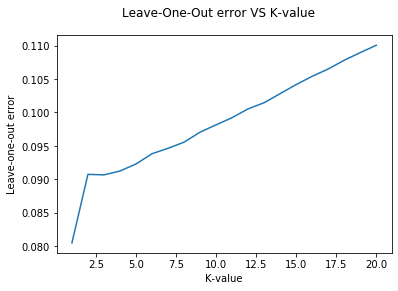

In [8]:
# Assign the dimensions of training image, training label, and the K-value
X = X_train[randindex,:]
y = y_train[randindex]
K = range(1,21)
loo_err = Leave_one_out_error(X, y, K)

# Plot leave-one-out error VS K-value 
plt.plot(K, loo_err)
plt.ylabel('Leave-one-out error')
plt.xlabel('K-value')
plt.suptitle('Leave-One-Out error VS K-value')

print('Best Error value: '+str(min(loo_err)))
print('at K-value: '+str(loo_err.index(min(loo_err))+1))

We can see that we found the best K-value, so we should look at how the prediction error was across each value. 

In [9]:
def Loo_table(X, y, K):
    # print(X.shape)
    # print(y.shape)
    ytests = []
    ypreds = []   
    model = neighbors.KNeighborsClassifier(n_neighbors = K)
    loo = sklearn.model_selection.LeaveOneOut()
    for train_idx, test_idx in loo.split(X):
        X_train_loo, X_test_loo = X[train_idx], X[test_idx]
        y_train_loo, y_test_loo = y[train_idx], y[test_idx]
        model.fit(X = X_train_loo, y = y_train_loo)
        y_pred = model.predict(X_test_loo)

        ytests += list(y_test_loo)
        ypreds += list(y_pred)

    cm = confusion_matrix(ytests, ypreds)
    tp = np.diag(cm).astype(float)
    fp = (cm.sum(axis=0)-tp).astype(float)
    fn = (cm.sum(axis=1)-tp).astype(float)
    tn = (cm.sum() - tp - fp - fn).astype(float)

    test_error_table(tp, fp, fn, tn)

    return test_error_table

In [10]:
# k = 7 gives the lowest error
X = X_train[randindex,:]
y = y_train[randindex]
K = loo_err.index(min(loo_err))+1
Loo_table(X, y, K)

+---------------+--------+--------+-------+-------+-------+-------+--------+--------+--------+--------+
| k_value\label |   0    |   1    |   2   |   3   |   4   |   5   |   6    |   7    |   8    |   9    |
+---------------+--------+--------+-------+-------+-------+-------+--------+--------+--------+--------+
|       1       | 0.0055 | 0.0115 | 0.014 | 0.021 | 0.017 | 0.021 | 0.0085 | 0.0145 | 0.0215 | 0.0265 |
+---------------+--------+--------+-------+-------+-------+-------+--------+--------+--------+--------+


<function __main__.test_error_table(tp, fp, fn, tn)>

We see that with K=7, we find similar errors for each digit, with '9' as the highest with a 3.4% error.

##### iii) (20 pts) Implement a function that downsamples the image by a factor of n. For example, if n is 4 then you will sample every 4th pixel (feature) in the 784-dimension feature vector. Repeat the KNN leave-one-out experiment with at least 4 different values of n. Comment on the testing results and the query time of the classifier.

The last problem took a considerable amount of time, even with only 2000 images. Downsampling can improve our computational efficiency by reducing the number in our 784-dimension feature vector. We can sample every nth value from an array of flattened images using simple index slicing. We can implement this as a function called `nDownsample(array, n)` and test on our flattened `X_train` images by sampling every 4th, or nth, pixel.

In [11]:
def nDownsample(array, n):
    downsample=(array[:,::n])
    return downsample

In [12]:
print('Original X_train: '+str(X_train.shape))
X_train_ndown = nDownsample(X_train,4)
print('Downsampled X_train: '+str(X_train_ndown.shape))

Original X_train: (60000, 784)
Downsampled X_train: (60000, 196)


This greatly reduces the a feature vector to just dimension/n, so 784/4=196. We can see how this affects our testing results and query time by varying the downsampling size, n. 

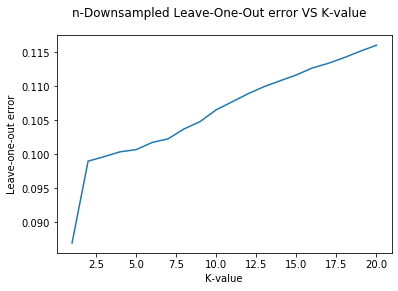

For n: 2
Best Error value: 0.087
at K-value: 1


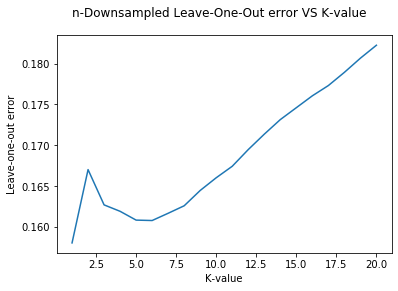

For n: 4
Best Error value: 0.158
at K-value: 1


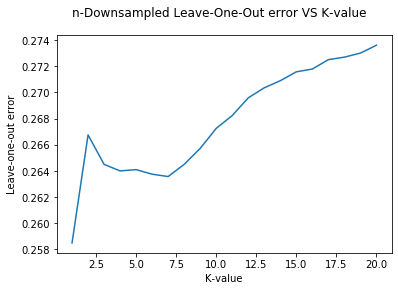

For n: 7
Best Error value: 0.2585
at K-value: 1


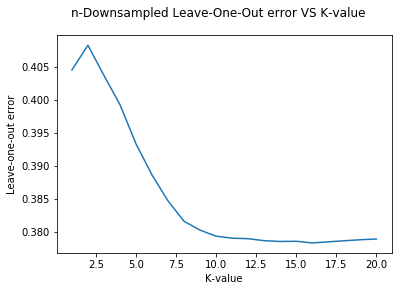

For n: 14
Best Error value: 0.37828
at K-value: 16


In [13]:
n_values = [2,4,7,14]
for i in n_values:
    X_train_ndown = nDownsample(X_train,i)
    X_test_ndown = nDownsample(X_test,i)
    # Assign the dimensions of training image, training label, and the K-value
    X = X_train_ndown[randindex,:]
    y = y_train[randindex]
    K = range(1,21)
    loo_err = Leave_one_out_error(X, y, K)

    # Plot leave-one-out error VS K-value 
    plt.plot(K, loo_err)
    plt.ylabel('Leave-one-out error')
    plt.xlabel('K-value')
    plt.suptitle('n-Downsampled Leave-One-Out error VS K-value')
    plt.show()
    print('For n: '+ str(i))
    print('Best Error value: '+str(min(loo_err)))
    print('at K-value: '+str(loo_err.index(min(loo_err))+1))

We see slight computational improvement as n increases, however we also see our error get worse as n increases. This down sampling is gridded, and also blatantly removes values, so we should not expect any big accuracy improvements. 

##### iv) (20 pts) Implement a function that smart downsamples the image by binning nearby pixels. For example, if n is 4 then the 28x28 image will be binned down to a 7x7 image by summing each 4x4 block in the image. Repeat the KNN leave-one-out experiment with at least 4 different values of n. Comment on the testing results and the query time of the classifier.

This smart downsampling came about in a discussion for SciKit's skimage package. We can use the function `block_reduce(image, block_size, func...)` to implement this. For example, we can use a block size of (4,4) and `np.sum` function as func. We will illustrate this with an image from our unflattened `my_dic['image_train']` array. 

https://github.com/scikit-image/scikit-image/issues/492
https://scikit-image.org/docs/dev/api/skimage.measure.html?#block-reduce

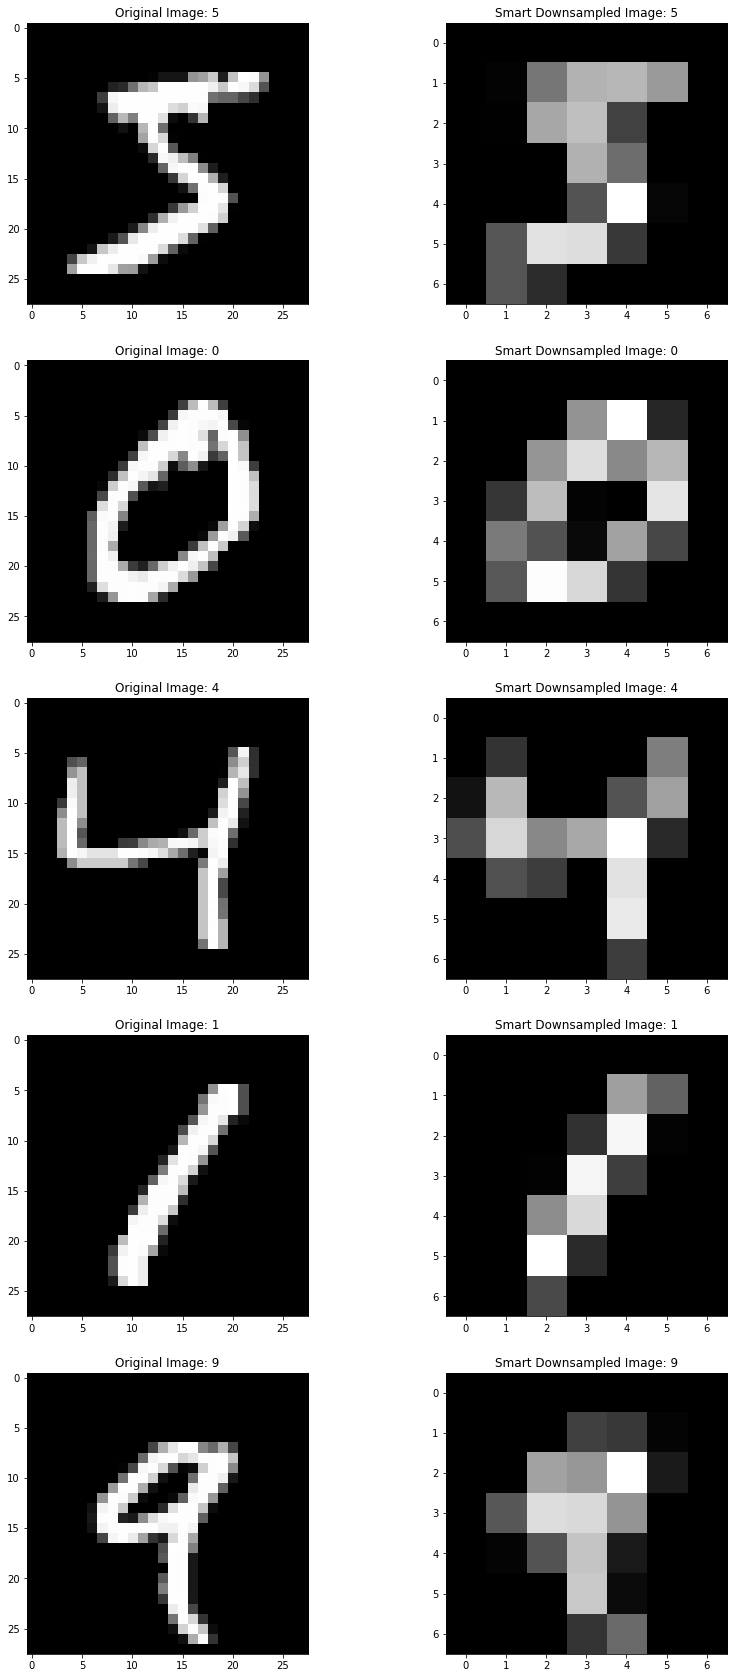

In [14]:
someImages = [0,1,2,3,4]
fig, axs = plt.subplots(len(someImages),2, figsize=(15,30))
plt.subplots_adjust(wspace=.001, hspace=.2)
for index,image in enumerate(someImages):
    image1 = my_dic['image_train'][image]
    axs[index,0].imshow(image1, cmap='Greys_r')
    axs[index,0].set_title('Original Image: '+str(my_dic['label_train'][image]))
    image2=skimage.measure.block_reduce(my_dic['image_train'][image],(4,4),func=np.sum)
    axs[index,1].imshow(image2, cmap='Greys_r')
    axs[index,1].set_title('Smart Downsampled Image: '+str(my_dic['label_train'][image]))

This type of downsampling is more intuitive in that it aggregates the pixels instead of outright removal. These images just appear at a lower resolution. We can now implement the `smartDownsample(image, n)` function to iterate over the entire image array, returning the smartly downsampled images.

In [15]:
def smartDownsample(images, n):
    downsampled_images = np.empty((int(images.shape[0]),
                                   int(images.shape[1]/n),
                                   int(images.shape[2]/n)))
    for index,image in enumerate(images):
        down=skimage.measure.block_reduce(image,(n,n),func=np.sum)
        downsampled_images[index] = down
    return downsampled_images

In [16]:
print("Original Training Array: "+str(my_dic['image_train'].shape))
image_train_down = smartDownsample(my_dic['image_train'],4)
print("Smart Downsampled Training Array: "+str(image_train_down.shape))

Original Training Array: (60000, 28, 28)
Smart Downsampled Training Array: (60000, 7, 7)


We will see how this more intuitively reduced size affects our performance and query time by repeating the loop from above.

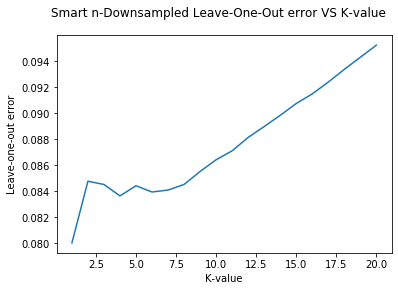

For n: 2
Best Error value: 0.08
at K-value: 1


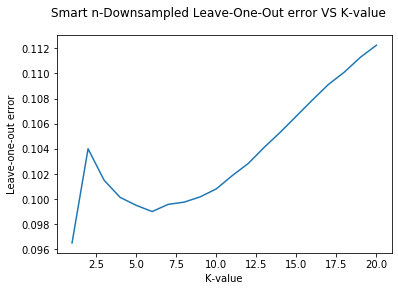

For n: 4
Best Error value: 0.0965
at K-value: 1


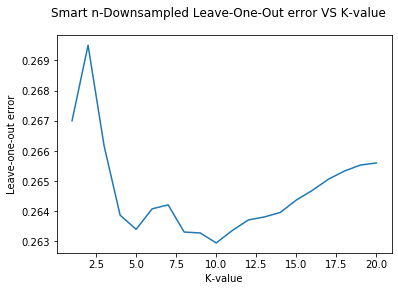

For n: 7
Best Error value: 0.26295
at K-value: 10


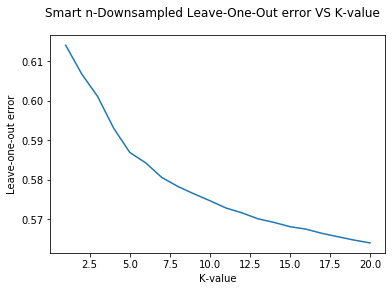

For n: 14
Best Error value: 0.56402
at K-value: 20


In [17]:
n_values = [2,4,7,14]
for i in n_values:
    X_train_ndown = smartDownsample(my_dic['image_train'],i).reshape(60000, int((28/i)*(28/i)))
    #print(X_train_ndown.shape)
    X_test_ndown = smartDownsample(my_dic['image_test'],i).reshape(10000, int((28/i)*(28/i)))
    #print(X_test_ndown.shape)
    # Assign the dimensions of training image, training label, and the K-value
    X = X_train_ndown[randindex,:]
    y = y_train[randindex]
    K = range(1,21)
    loo_err = Leave_one_out_error(X, y, K)

    # Plot leave-one-out error VS K-value 
    plt.plot(K, loo_err)
    plt.ylabel('Leave-one-out error')
    plt.xlabel('K-value')
    plt.suptitle('Smart n-Downsampled Leave-One-Out error VS K-value')
    plt.show()
    print('For n: '+ str(i))
    print('Best Error value: '+str(min(loo_err)))
    print('at K-value: '+str(loo_err.index(min(loo_err))+1))

We can see that our query speed increased with each increase in factor. But this time, we found a better error at n=2, K=6, and a very comparable error with n=4, K=7, before the error increased with higher factors (n). It might make sense, depending on where and how this model will be used to downsample if the slightly decreased accuracy is allowable. 

##### v) (10 pts) Run your smart downsampler at n = 28. Essentially, reduce each image down to 1 pixel by summing them all. The motivation here is that an '8' will obviously have more dark pixels than a '1' . Repeat the KNN leave-one-out experiment. Comment on the testing results and the query time of the classifier.

Original Training Array: (60000, 28, 28)
Smart Downsampled Training Array: (60000, 1, 1)


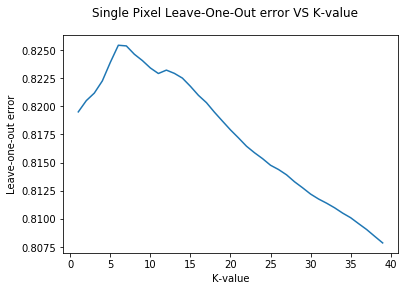

Best Error value: 0.80786
at K-value: 39


In [18]:
print("Original Training Array: "+str(my_dic['image_train'].shape))
image_train_down = smartDownsample(my_dic['image_train'],28)
print("Smart Downsampled Training Array: "+str(image_train_down.shape))
X_train_ndown = smartDownsample(my_dic['image_train'],28).reshape(60000, 1)
# Assign the dimensions of training image, training label, and the K-value
X = X_train_ndown[randindex,:]
y = y_train[randindex]
K = range(1,40)
loo_err = Leave_one_out_error(X, y, K)

# Plot leave-one-out error VS K-value 
plt.plot(K, loo_err)
plt.ylabel('Leave-one-out error')
plt.xlabel('K-value')
plt.suptitle('Single Pixel Leave-One-Out error VS K-value')
plt.show()

print('Best Error value: '+str(min(loo_err)))
print('at K-value: '+str(loo_err.index(min(loo_err))+1))

We can see that the computational time was very fast, however the error is very high for this model. This is probably due to the variation in stroke width or thickness across all digits, depending on who is writing it. Interestingly, it required a large number of neighbors to really see the optimal K-value. This model needs a lot of bias to perform well, perhaps because the high bias introduced by downsampling so severely.

##### vi) (30 pts) Do a little research of your own and develop a feature transformation method that you then use with the KNN leave-one-out experiment. Describe your method in detail, using equations and figures as necessary. Someone should be able to reproduce your results with your description. Comment on the testing results and the query time of the classifier.

We can first try implementing a PCA transformation on the data. This was suggested through discussion among peers to reduce the effect of rotation from handwriting. 

In [19]:
pca=PCA()
X_train_pca = pca.fit_transform(X_train)

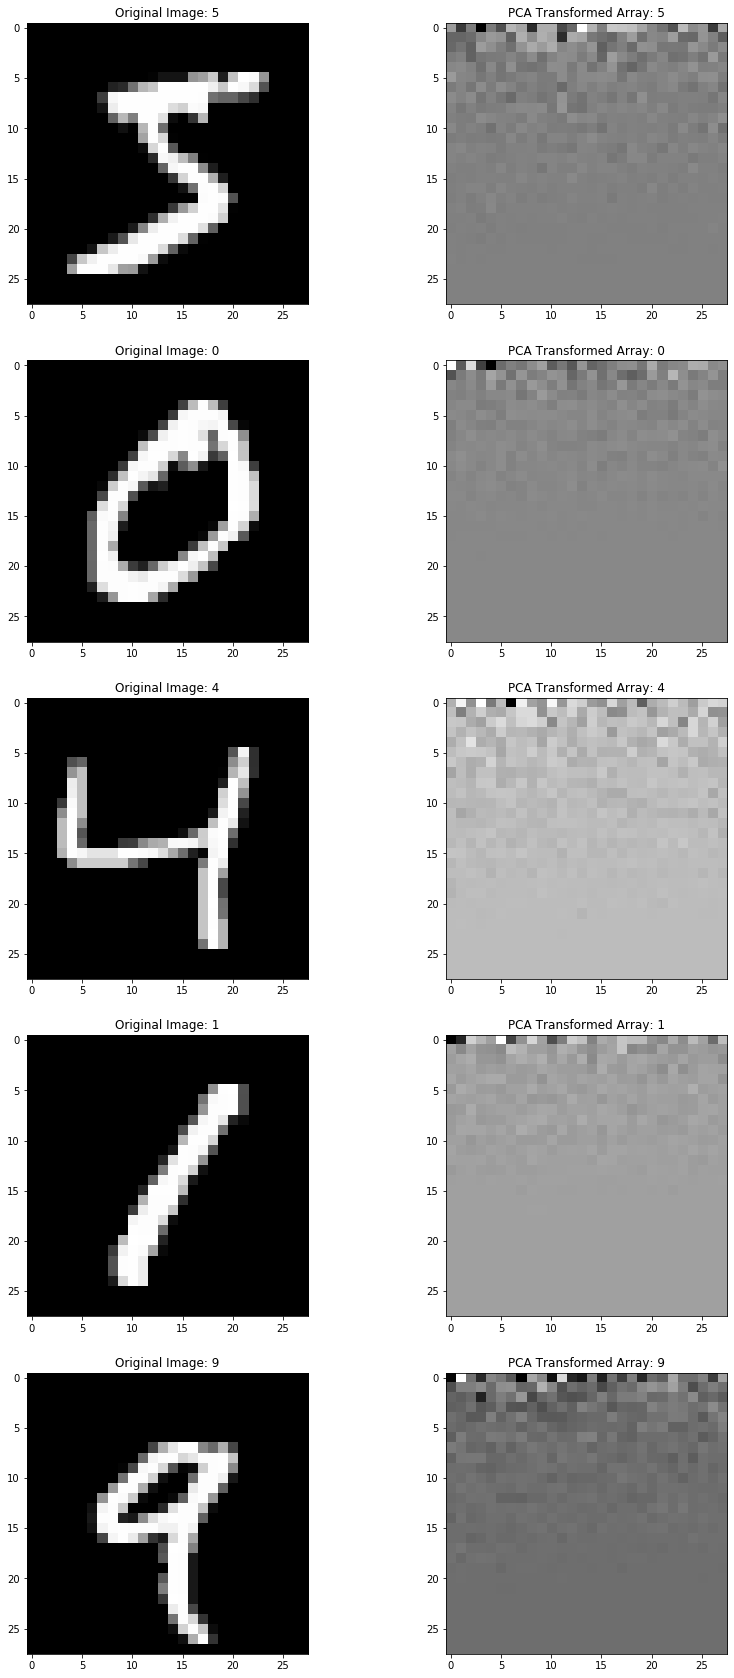

In [20]:
someImages = [0,1,2,3,4]
fig, axs = plt.subplots(len(someImages),2, figsize=(15,30))
plt.subplots_adjust(wspace=.001, hspace=.2)
for index,image in enumerate(someImages):
    image1 = my_dic['image_train'][image]
    axs[index,0].imshow(image1, cmap='Greys_r')
    axs[index,0].set_title('Original Image: '+str(my_dic['label_train'][image]))
    image2=np.reshape(X_train_pca[image,:], (28,28))
    axs[index,1].imshow(image2, cmap='Greys_r')
    axs[index,1].set_title('PCA Transformed Array: '+str(y_train[image]))

It is clear that the pixels are no longer interpretable by the human eye, but different digits certainly show different encodings of the higher ranked principle components. This unsupervised method maximizes the variance between components to increase accuracy, but without setting a threshold and removing seemingly unimportant components, we won't see any computational gains. 

What if we downsampled by some factor before doing PCA? We found strong results by smart downsampling with a factor of n=2.

In [21]:
i = 2
X_train_ndown = smartDownsample(my_dic['image_train'],i).reshape(60000, int((28/i)*(28/i)))
print(X_train_ndown.shape)
pca=PCA()
X_train_ndown_pca = pca.fit_transform(X_train_ndown)

(60000, 196)


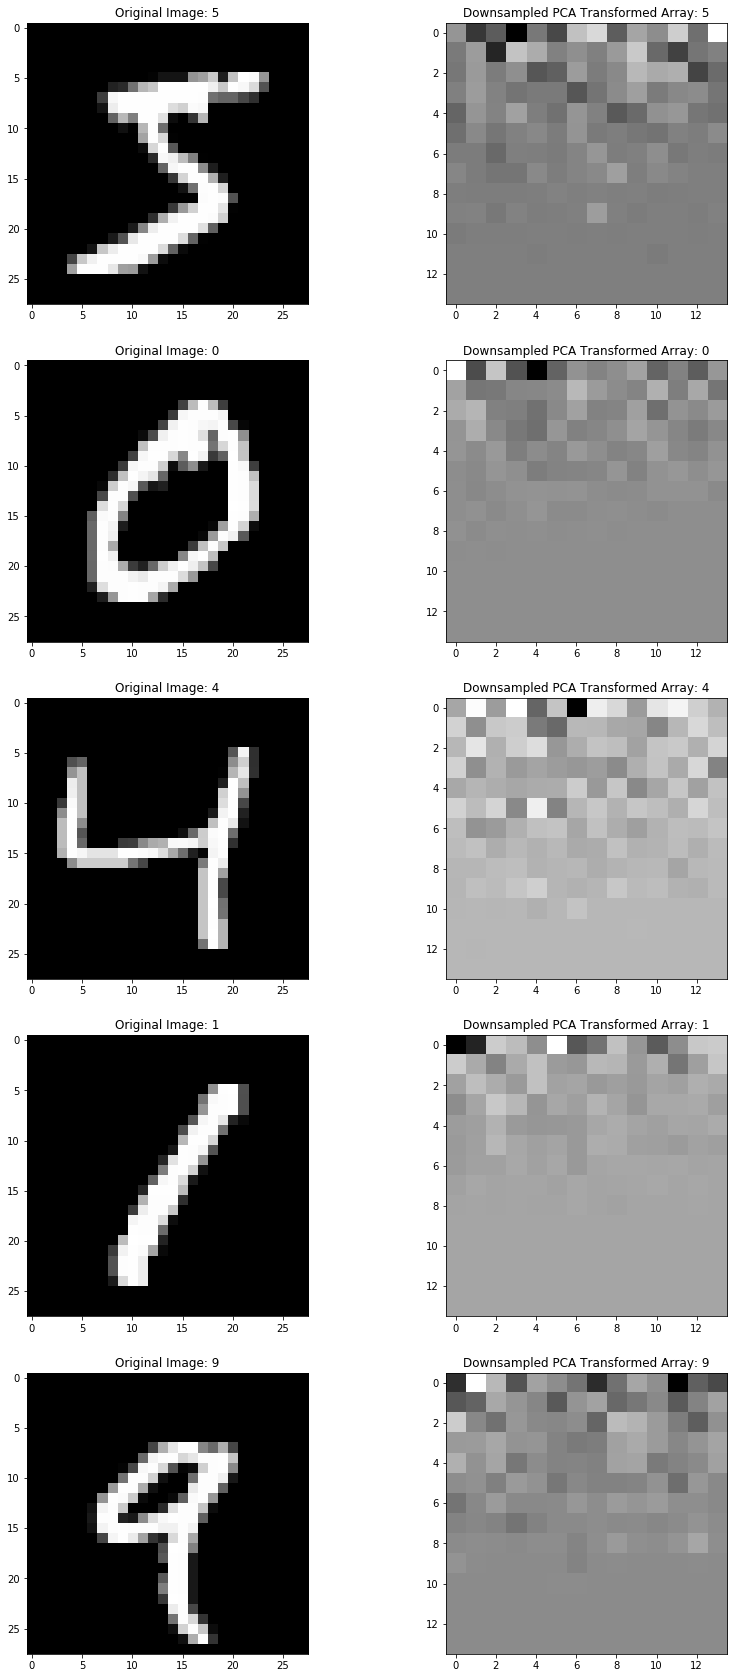

In [22]:
someImages = [0,1,2,3,4]
fig, axs = plt.subplots(len(someImages),2, figsize=(15,30))
plt.subplots_adjust(wspace=.001, hspace=.2)
for index,image in enumerate(someImages):
    image1 = my_dic['image_train'][image]
    axs[index,0].imshow(image1, cmap='Greys_r')
    axs[index,0].set_title('Original Image: '+str(my_dic['label_train'][image]))
    shp = int(math.sqrt(X_train_ndown_pca.shape[1]))
    image2=np.reshape(X_train_ndown_pca[image,:], (shp,shp))
    axs[index,1].imshow(image2, cmap='Greys_r')
    axs[index,1].set_title('Downsampled PCA Transformed Array: '+str(y_train[image]))

It appears that about half the image shows any type of meaningful information as numbers change, so we will plan on retaining 98 out of 196 principal components for the training features. We can test our new training data the same way as before. 

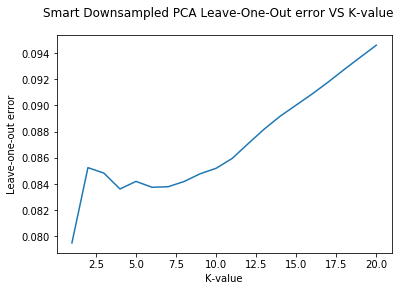

Best Error value: 0.0795
at K-value: 1


In [23]:
# Assign the dimensions of training image, training label, and the K-value
X = X_train_ndown_pca[randindex,0:98]
y = y_train[randindex]
K = range(1,21)
loo_err = Leave_one_out_error(X, y, K)

# Plot leave-one-out error VS K-value 
plt.plot(K, loo_err)
plt.ylabel('Leave-one-out error')
plt.xlabel('K-value')
plt.suptitle('Smart Downsampled PCA Leave-One-Out error VS K-value')
plt.show()

print('Best Error value: '+str(min(loo_err)))
print('at K-value: '+str(loo_err.index(min(loo_err))+1))

Our results seem to be slightly better, however there is no huge improvement, perhaps 0.2% less error. 

An additional feature transformation method that shows good results in this experiment is Linear Discriminant Analysis applied after Principal Component Analysis.
Linear Discriminant Analysis (LDA) is a supervised dimension reduction method that can find the best linear projection based on Fisher's discriminants such that two classes of samples are well separated.  The method is used to transform variable of one set into another smaller set.    Because the data is now transformed into a smaller set, the data distribution can achieve the objective of maximizing the between-class distance and minimizing the within-class distance.  In order to achieve this, two measures are introduced to all feature vectors: within-class scatter matrix (SW), where  N is the number of classes, ni the number of samples in the ith class, represents the jth sample of the ith class, and μi the mean of class and between-class scatter matrix (SB): where μall is the mean of all classes.  Below are the equations for both the between class and within class variance:

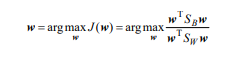

Based on Fisher’s discriminants, the projection w that best separates the two classes should satisfy:   

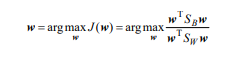

The standard LDA can be seriously degraded if there are a limited number of observations in comparison to the feature space.  To prevent this, we first perform a principal component analysis (PCA), which is then followed by LDA.  Although our dataset was reasonably large, we still found better results when employing this feature transformation method to just PCA.  In PCA, the shape and location of the original data sets changes when transformed to a new feature space. LDA does not change the location but only focuses on providing more separability between classes and then draw a decision region between the specified classes. 

https://arxiv.org/ftp/arxiv/papers/1204/1204.1177.pdf

https://www.sciencedirect.com/science/article/abs/pii/S0031320304004066

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda=LinearDiscriminantAnalysis()

X_train_lda = lda.fit_transform(X_train_pca[:,0:98], y_train)

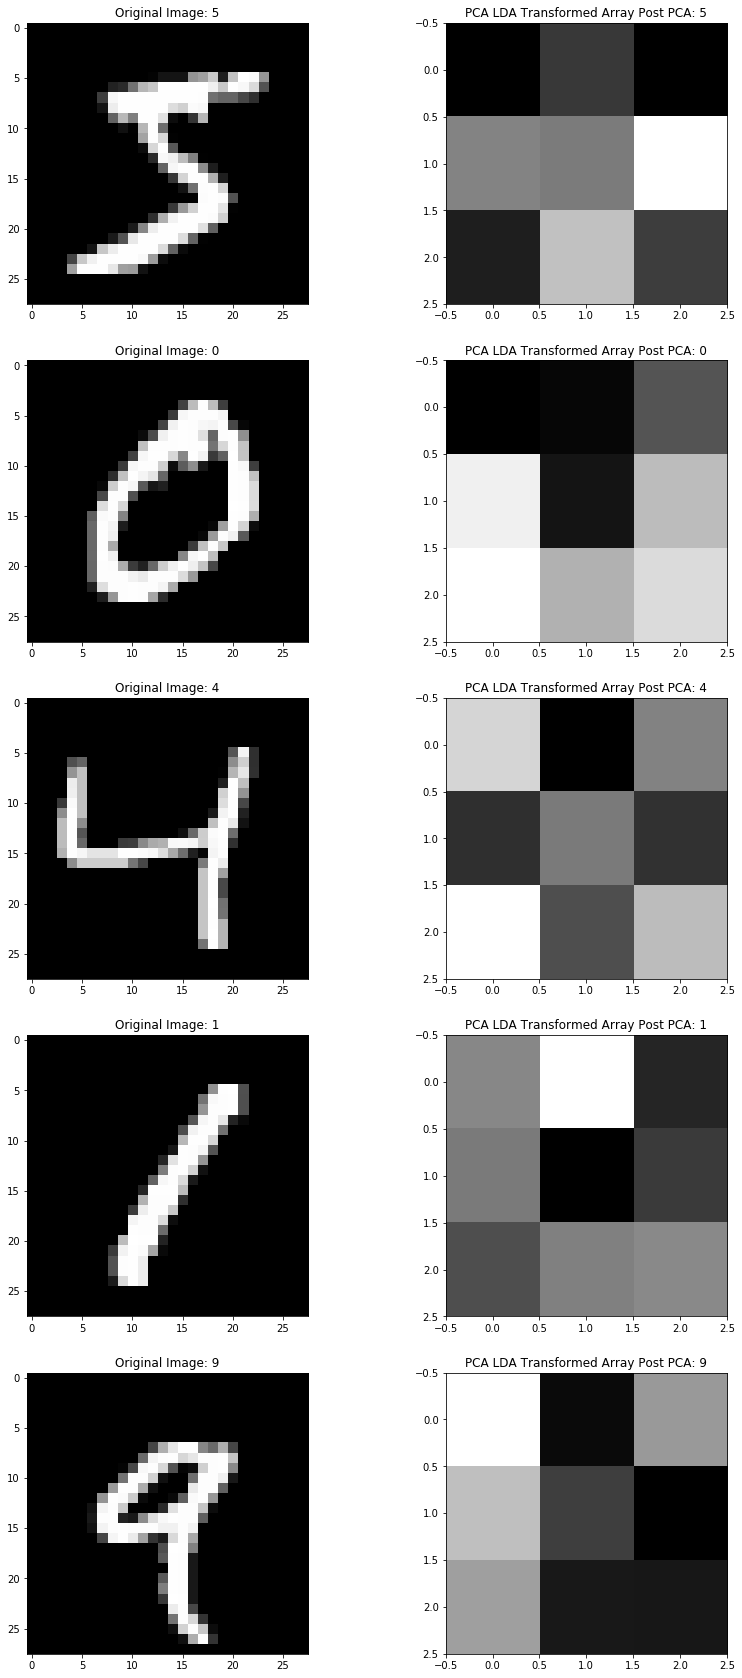

In [25]:
someImages = [0,1,2,3,4]
fig, axs = plt.subplots(len(someImages),2, figsize=(15,30))
plt.subplots_adjust(wspace=.001, hspace=.2)
for index,image in enumerate(someImages):
    image1 = my_dic['image_train'][image]
    axs[index,0].imshow(image1, cmap='Greys_r')
    axs[index,0].set_title('Original Image: '+str(my_dic['label_train'][image]))
    shp = int(math.sqrt(X_train_lda.shape[1]))
    image2=np.reshape(X_train_lda[image,:], (shp,shp))
    axs[index,1].imshow(image2, cmap='Greys_r')
    axs[index,1].set_title('PCA LDA Transformed Array Post PCA: '+str(y_train[image]))

The images show some promising results, let us cross validate to find the best KNN model using the same sample from the transformed training data.

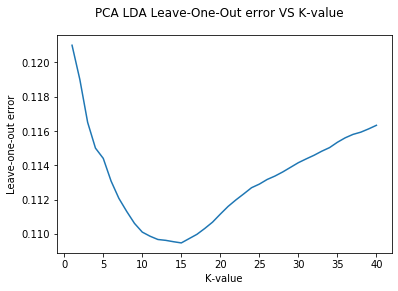

Best Error value: 0.10947
at K-value: 15


In [26]:
# Assign the dimensions of training image, training label, and the K-value
X = X_train_lda[randindex,:]
y = y_train[randindex]
K = range(1,41)
loo_err = Leave_one_out_error(X, y, K)

# Plot leave-one-out error VS K-value 
plt.plot(K, loo_err)
plt.ylabel('Leave-one-out error')
plt.xlabel('K-value')
plt.suptitle('PCA LDA Leave-One-Out error VS K-value')
plt.show()

print('Best Error value: '+str(min(loo_err)))
print('at K-value: '+str(loo_err.index(min(loo_err))+1))

We might also check to see if the there is any improvement by using our smart downsampled (factor of 2) PCA transformed data. 

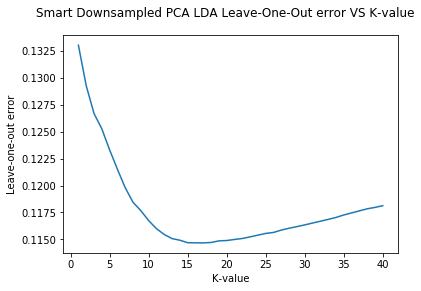

Best Error value: 0.11468
at K-value: 17


In [27]:
X_train_ndown_lda = lda.fit_transform(X_train_ndown_pca[:,0:98], y_train)
# Assign the dimensions of training image, training label, and the K-value
X = X_train_ndown_lda[randindex,:]
y = y_train[randindex]
K = range(1,41)
loo_err = Leave_one_out_error(X, y, K)

# Plot leave-one-out error VS K-value 
plt.plot(K, loo_err)
plt.ylabel('Leave-one-out error')
plt.xlabel('K-value')
plt.suptitle('Smart Downsampled PCA LDA Leave-One-Out error VS K-value')
plt.show()

print('Best Error value: '+str(min(loo_err)))
print('at K-value: '+str(loo_err.index(min(loo_err))+1))

The results seem no better with the the LDA as compared to the 2 factor smart downsampling. The query timing of each is close with no discernable differences. 

The best method we are able to show with the `randindex` sample (2500 images) of the image set seems to be 2 factor smart downsampling the data using `skimage.block_reduce()`, then performing a PCA transformation retaining half the components, which we trained with leave-one-out cross validation a 6-nearest neighbor classifier. 

We can validate our model on the first 1000 images from the test set.

In [28]:
#transform X_test data
i = 2
X_test_ndown = smartDownsample(my_dic['image_test'],i).reshape(10000, int((28/i)*(28/i)))
X_test_ndown_pca = pca.transform(X_test_ndown)
# Assign the dimensions of training image, training label, and the K-value
X = X_train_ndown_pca[randindex,0:98]
y = y_train[randindex]
# fitting
knn = neighbors.KNeighborsClassifier(n_neighbors = 6)
knn.fit(X,y)

# prediction on first 1000 points from test dataset
y_pred = knn.predict(X_test_ndown_pca[0:1000,0:98])
# comfusion matrix
acc = metrics.accuracy_score(y_test[0:1000], y_pred)  
err = round(1-acc, 5)
print('Error: '+str(err))

Error: 0.093


This validates our thinking that this is a good model.